In [1]:
#imports and set up
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay as pdp
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)

RANDOM_SEED = 42

In [2]:
#loading data
FPL_API_URL = "https://fantasy.premierleague.com/api/bootstrap-static/"

def load_fpl_data():
    raw_data = requests.get(FPL_API_URL)
    raw_data.raise_for_status()
    data = raw_data.json()
    
    players = pd.DataFrame(data["elements"])
    teams = pd.DataFrame(data["teams"])
    positions = pd.DataFrame(data["element_types"])
    
    return players, teams, positions


players, teams, positions = load_fpl_data()


FIXTURES_URL = "https://fantasy.premierleague.com/api/fixtures/"

def load_fixtures():
    r = requests.get(FIXTURES_URL)
    r.raise_for_status()
    return pd.DataFrame(r.json())

fixtures = load_fixtures()


players.head()
fixtures.head()


,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2561895,1,True,True,1,2025-08-15T19:00:00Z,90,False,True,4,2.00,12,4.00,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,4,124791
1,2561896,1,True,True,2,2025-08-16T11:30:00Z,90,False,True,15,0.00,2,0.00,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,3,124792
2,2561897,1,True,True,3,2025-08-16T14:00:00Z,90,False,True,10,1.00,6,1.00,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,3,124793
3,2561900,1,True,True,6,2025-08-16T14:00:00Z,90,False,True,3,0.00,18,3.00,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,3,124796
4,2561899,1,True,True,5,2025-08-16T14:00:00Z,90,False,True,19,0.00,17,3.00,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,3,124795


In [3]:
#viewing and cleaning base data table
base_cols = [
    "id", "first_name", "second_name", "team",
    "element_type", "now_cost", "minutes",
    "goals_scored", "assists", "clean_sheets",
    "goals_conceded", "total_points",
    "form", "points_per_game", "selected_by_percent"
]

df = players[base_cols].copy()

df["name"] = df["first_name"] + " " + df["second_name"]
df["price"] = df["now_cost"] / 10
df["form"] = df["form"].astype(float)
df["games_played"] = np.where(df["points_per_game"].astype(float) > 0 , df["total_points"].astype(float) / df["points_per_game"].astype(float),0)

df.head()


#mapping teams and positions
team_map = teams.set_index("id")["name"].to_dict()
pos_map = positions.set_index("id")["singular_name"].to_dict()

df["team_name"] = df["team"].map(team_map)
df["position"] = df["element_type"].map(pos_map)

df.head()

,id,first_name,second_name,team,element_type,now_cost,minutes,goals_scored,assists,clean_sheets,goals_conceded,total_points,form,points_per_game,selected_by_percent,name,price,games_played,team_name,position
0,1,David,Raya Martín,1,1,59,2160,0,0,12,17,99,4.00,4.1,33.3,David Raya Martín,5.90,24.15,Arsenal,Goalkeeper
1,2,Kepa,Arrizabalaga Revuelta,1,1,41,0,0,0,0,0,0,0.00,0.0,0.4,Kepa Arrizabalaga Revuelta,4.10,0.00,Arsenal,Goalkeeper
2,3,Karl,Hein,1,1,40,0,0,0,0,0,0,0.00,0.0,0.2,Karl Hein,4.00,0.00,Arsenal,Goalkeeper
3,4,Tommy,Setford,1,1,39,0,0,0,0,0,0,0.00,0.0,0.2,Tommy Setford,3.90,0.00,Arsenal,Goalkeeper
4,5,Gabriel,dos Santos Magalhães,1,2,70,1535,3,2,11,10,129,6.40,7.2,39.3,Gabriel dos Santos Magalhães,7.00,17.92,Arsenal,Defender


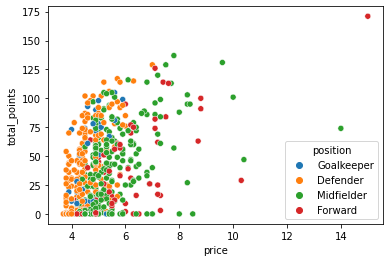

In [4]:
#EDA - skew, low mins, high premiums
#df[["total_points", "price", "minutes", "form"]].hist(bins=30, figsize=(12,6))
#plt.show()

sns.scatterplot(data=df, x="price", y="total_points", hue="position")
plt.show()



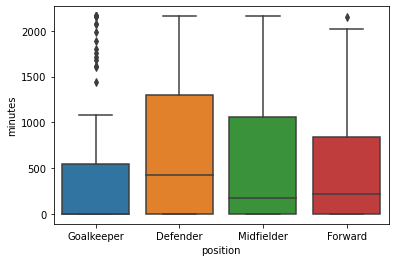

In [5]:
sns.boxplot(data=df, x="position", y="minutes")
plt.show()

In [6]:
#feature engineering - add in the other players data once defined
df["points_per_90"] = np.where(
    df["minutes"] > 0,
    df["total_points"] / df["minutes"] * 90,
    0
)

df["goal_involvements"] = df["goals_scored"] + df["assists"]
df["GI_per_90"] = np.where(
    df["minutes"] > 0,
    df["goal_involvements"] / df["minutes"] * 90,
    0
)

df

df["min_per_gw"] = np.where(df["games_played"] > 0, 
                            df["minutes"]/df["games_played"],
                                          0)

df["value"] = df["total_points"] / df["price"]
df["points_per_million"] = df["total_points"] / df["price"]
df["x_value"] = df["points_per_90"] / df["price"]

df.head()

,id,first_name,second_name,team,element_type,now_cost,minutes,goals_scored,assists,clean_sheets,goals_conceded,total_points,form,points_per_game,selected_by_percent,name,price,games_played,team_name,position,points_per_90,goal_involvements,GI_per_90,min_per_gw,value,points_per_million,x_value
0,1,David,Raya Martín,1,1,59,2160,0,0,12,17,99,4.00,4.1,33.3,David Raya Martín,5.90,24.15,Arsenal,Goalkeeper,4.12,0,0.00,89.45,16.78,16.78,0.70
1,2,Kepa,Arrizabalaga Revuelta,1,1,41,0,0,0,0,0,0,0.00,0.0,0.4,Kepa Arrizabalaga Revuelta,4.10,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00
2,3,Karl,Hein,1,1,40,0,0,0,0,0,0,0.00,0.0,0.2,Karl Hein,4.00,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00
3,4,Tommy,Setford,1,1,39,0,0,0,0,0,0,0.00,0.0,0.2,Tommy Setford,3.90,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00
4,5,Gabriel,dos Santos Magalhães,1,2,70,1535,3,2,11,10,129,6.40,7.2,39.3,Gabriel dos Santos Magalhães,7.00,17.92,Arsenal,Defender,7.56,5,0.29,85.67,18.43,18.43,1.08


In [7]:
#fixtures features - fixture difficulty over next 3 games
def fixture_features(fixtures, teams, horizon=3):
    team_id_to_name = teams.set_index("id")["name"].to_dict()
    
    records = []
    
    for team_id in teams["id"]:
        team_fixtures = fixtures[
            (fixtures["team_h"] == team_id) |
            (fixtures["team_a"] == team_id)
        ].sort_values("event")
        
        next_games = team_fixtures.head(horizon)
        
        difficulties = []
        home_flags = []
        
        for _, row in next_games.iterrows():
            if row["team_h"] == team_id:
                difficulties.append(row["team_h_difficulty"])
                home_flags.append(1)
            else:
                difficulties.append(row["team_a_difficulty"])
                home_flags.append(0)
        
        records.append({
            "team": team_id,
            "avg_fdr": np.mean(difficulties) if difficulties else np.nan,
            "home_ratio": np.mean(home_flags) if home_flags else np.nan
        })
    
    return pd.DataFrame(records)

fixture_features = fixture_features(fixtures, teams)


fixture_features["fdr_multiplier"] = 1.6 - (fixture_features["avg_fdr"] / 5)
fixture_features["fdr_multiplier"] = fixture_features["fdr_multiplier"].clip(0.7, 1.3)
fixture_features.head()

,team,avg_fdr,home_ratio,fdr_multiplier
0,1,3.00,0.33,1.00
1,2,3.00,0.67,1.00
2,3,2.67,0.33,1.07
3,4,3.00,0.33,1.00
4,5,3.00,0.33,1.00


In [8]:
#merging new features
df = df.merge(fixture_features, left_on="team", right_on="team", how="left")
df.head()

,id,first_name,second_name,team,element_type,now_cost,minutes,goals_scored,assists,clean_sheets,goals_conceded,total_points,form,points_per_game,selected_by_percent,name,price,games_played,team_name,position,points_per_90,goal_involvements,GI_per_90,min_per_gw,value,points_per_million,x_value,avg_fdr,home_ratio,fdr_multiplier
0,1,David,Raya Martín,1,1,59,2160,0,0,12,17,99,4.00,4.1,33.3,David Raya Martín,5.90,24.15,Arsenal,Goalkeeper,4.12,0,0.00,89.45,16.78,16.78,0.70,3.00,0.33,1.00
1,2,Kepa,Arrizabalaga Revuelta,1,1,41,0,0,0,0,0,0,0.00,0.0,0.4,Kepa Arrizabalaga Revuelta,4.10,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00,3.00,0.33,1.00
2,3,Karl,Hein,1,1,40,0,0,0,0,0,0,0.00,0.0,0.2,Karl Hein,4.00,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00,3.00,0.33,1.00
3,4,Tommy,Setford,1,1,39,0,0,0,0,0,0,0.00,0.0,0.2,Tommy Setford,3.90,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00,3.00,0.33,1.00
4,5,Gabriel,dos Santos Magalhães,1,2,70,1535,3,2,11,10,129,6.40,7.2,39.3,Gabriel dos Santos Magalhães,7.00,17.92,Arsenal,Defender,7.56,5,0.29,85.67,18.43,18.43,1.08,3.00,0.33,1.00


In [9]:
#interactions
df["form_x_minutes"] = df["form"] * (df["minutes"] / df["minutes"].max())
df["price_x_form"] = df["price"] * df["form"]

In [10]:
#non ML expected points score
def expected_points(row):
    score = 0
    score += row["points_per_90"] * 0.6
    score += float(row["form"]) * 0.3
    score += min(row["minutes"] / 90, 1) * 2
    score += row["value"] * 0.05
    return score


df["xPoints"] = df.apply(expected_points, axis=1)
df["adj_xPoints"] = df["xPoints"] * df["fdr_multiplier"]

def rank_by_position(position, top_n=10):
    return (
        df[df["position"] == position][df["min_per_gw"] > 45]
        .sort_values("adj_xPoints", ascending=False)
        .head(top_n)
        [["name", "team_name", "price", "xPoints", "points_per_90", "form", "min_per_gw", "avg_fdr", "home_ratio"]]
    )

rank_by_position("Midfielder", 10)

/var/folders/k5/1b6xbllj60n_h0t0rl6r2ztm0000gn/T/ipykernel_81250/347234201.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["position"] == position][df["min_per_gw"] > 45]


,name,team_name,price,xPoints,points_per_90,form,min_per_gw,avg_fdr,home_ratio
278,Enzo Fernández,Chelsea,6.80,8.01,5.22,6.80,86.14,2.33,0.67
501,Rayan Cherki,Man City,6.60,8.23,7.68,3.20,53.88,2.67,0.33
538,Bruno Borges Fernandes,Man Utd,9.60,8.52,6.53,6.40,85.43,3.00,0.67
480,Antoine Semenyo,Man City,7.80,7.89,5.96,4.80,90.66,2.67,0.33
544,Carlos Henrique Casimiro,Man Utd,5.50,8.36,6.10,5.80,70.77,3.00,0.67
390,Harry Wilson,Fulham,6.10,8.24,5.92,5.80,76.03,3.00,0.33
19,Declan Rice,Arsenal,7.50,8.03,5.91,5.40,85.30,3.00,0.33
616,Morgan Gibbs-White,Nott'm Forest,7.30,7.38,4.34,7.00,84.98,2.67,0.67
618,Elliot Anderson,Nott'm Forest,5.30,7.26,4.33,5.60,89.31,2.67,0.67
539,Matheus Santos Carneiro da Cunha,Man Utd,8.00,7.73,5.33,6.60,70.88,3.00,0.67


In [24]:
X["selected_by_percent"] = X["selected_by_percent"].astype(float)
X.dtypes

form                   float64
minutes                  int64
points_per_million     float64
GI_per_90              float64
price                  float64
avg_fdr                float64
home_ratio             float64
selected_by_percent    float64
dtype: object

In [12]:
#quick selection
def shortlist(position, max_price, min_minutes=300):
    return (
        df[
            (df["position"] == position) &
            (df["price"] <= max_price) &
            (df["minutes"] >= min_minutes)
        ]
        .sort_values("xPoints", ascending=False)
    )

shortlist("Forward", max_price=8.0).head(10)

,id,first_name,second_name,team,element_type,now_cost,minutes,goals_scored,assists,clean_sheets,goals_conceded,total_points,form,points_per_game,selected_by_percent,name,price,games_played,team_name,position,points_per_90,goal_involvements,GI_per_90,min_per_gw,value,points_per_million,x_value,avg_fdr,home_ratio,fdr_multiplier,form_x_minutes,price_x_form,xPoints,adj_xPoints
161,100,Junior,Kroupi,4,4,47,772,8,0,4,16,64,4.40,3.4,5.8,Junior Kroupi,4.70,18.82,Bournemouth,Forward,7.46,8,0.93,41.01,13.62,13.62,1.59,3.00,0.33,1.00,1.57,20.68,8.48,8.48
209,136,Igor Thiago,Nascimento Rodrigues,5,4,71,2022,16,1,6,30,126,7.00,5.2,35.0,Igor Thiago Nascimento Rodrigues,7.10,24.23,Brentford,Forward,5.61,17,0.76,83.45,17.75,17.75,0.79,3.00,0.33,1.00,6.55,49.70,8.35,8.35
289,249,João Pedro,Junqueira de Jesus,7,4,74,1723,9,5,9,17,114,6.60,4.8,37.7,João Pedro Junqueira de Jesus,7.40,23.75,Chelsea,Forward,5.95,14,0.73,72.55,15.41,15.41,0.80,2.33,0.67,1.13,5.26,48.84,8.32,9.43
681,730,Brian,Brobbey,17,4,56,871,5,1,3,12,56,5.40,3.1,1.6,Brian Brobbey,5.60,18.06,Sunderland,Forward,5.79,6,0.62,48.22,10.00,10.00,1.03,2.33,0.67,1.13,2.18,30.24,7.59,8.60
434,365,Lukas,Nmecha,11,4,50,602,5,0,2,14,49,1.80,2.6,0.5,Lukas Nmecha,5.00,18.85,Leeds,Forward,7.33,5,0.75,31.94,9.80,9.80,1.47,3.33,0.67,0.93,0.50,9.00,7.43,6.93
754,624,Jarrod,Bowen,19,4,76,2150,8,3,1,47,113,5.80,4.7,8.6,Jarrod Bowen,7.60,24.04,West Ham,Forward,4.73,11,0.46,89.42,14.87,14.87,0.62,3.00,0.33,1.00,5.77,44.08,7.32,7.32
805,749,Mateus,Mané,20,4,46,716,2,2,2,12,40,5.40,3.1,2.0,Mateus Mané,4.60,12.90,Wolves,Forward,5.03,4,0.50,55.49,8.70,8.70,1.09,3.33,0.67,0.93,1.79,24.84,7.07,6.60
438,691,Dominic,Calvert-Lewin,11,4,60,1573,9,2,4,24,95,3.20,4.3,12.1,Dominic Calvert-Lewin,6.00,22.09,Leeds,Forward,5.44,11,0.63,71.20,15.83,15.83,0.91,3.33,0.67,0.93,2.33,19.20,7.01,6.55
758,671,Callum,Wilson,19,4,58,838,5,2,1,17,60,2.00,3.0,0.6,Callum Wilson,5.80,20.00,West Ham,Forward,6.44,7,0.75,41.90,10.34,10.34,1.11,3.00,0.33,1.00,0.78,11.60,6.98,6.98
556,681,Benjamin,Sesko,14,4,72,1063,5,2,1,23,62,4.40,3.3,3.3,Benjamin Sesko,7.20,18.79,Man Utd,Forward,5.25,7,0.59,56.58,8.61,8.61,0.73,3.00,0.67,1.00,2.17,31.68,6.90,6.90


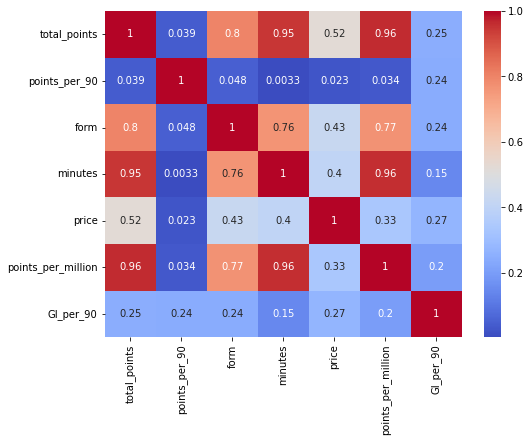

In [13]:
#correlation heatmap
corr_features = [
    "total_points", "points_per_90",
    "form", "minutes", "price",
    "points_per_million", "GI_per_90"
]

corr = df[corr_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [14]:
#ml workflow
response = "points_per_90"

#initial feature set - extend later
features = [
    "form",
    "minutes",
    "points_per_million",
    "GI_per_90",
    "price",
    "avg_fdr",
    "home_ratio",
    "selected_by_percent"
]

#rough cleaning - check for future imputing (after test/train split)
X = df[features].fillna(0)
y = df[response]

In [27]:
#test train split - train 0.7, tuning - 0.15, testing 0.15 - readjust if test too volatile
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [16]:
#base gbm

gbm = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbm.fit(X_train, y_train)

val_preds = gbm.predict(X_val)
mae = mae(y_val, val_preds)

print(f"Validation MAE: {mae:.3f}")

Validation MAE: 0.870


In [17]:
#hpt
param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.03, 0.05],
    "n_estimators": [200, 300]
}

grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

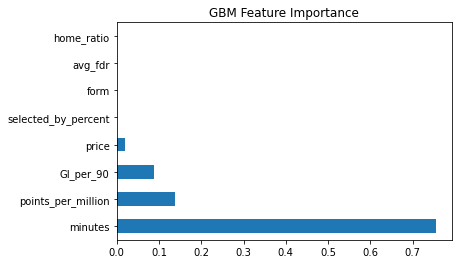

In [18]:
#feature importance from base model
importances = pd.Series(
    best_model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances.plot(kind="barh")
plt.title("GBM Feature Importance")
plt.show()

In [19]:
top_features = importances[importances > 0.05].index.tolist()

X_reduced = df[top_features].fillna(0)

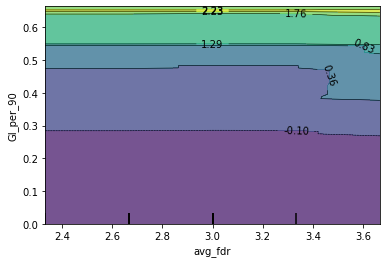

In [20]:
#pdps

pdp.from_estimator(
    best_model,
    X_train,
    features=[("avg_fdr", "GI_per_90")]
)
plt.show()

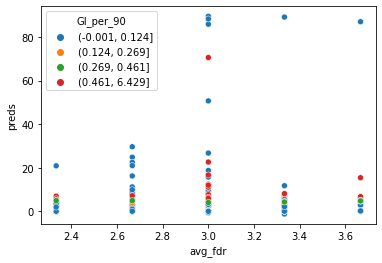

In [21]:
#interaction finder
interaction_df = X_train.copy()
interaction_df["preds"] = best_model.predict(X_train)

sns.scatterplot(
    data=interaction_df,
    x="avg_fdr",
    y="preds",
    hue=pd.qcut(interaction_df["GI_per_90"], 9, duplicates='drop')
)
plt.show()

In [28]:
#base xgb


xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=30,   
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_val_preds = xgb_model.predict(X_val)
xgb_mae = mae(y_val, xgb_val_preds)

print(f"XGBoost Validation MAE: {xgb_mae:.3f}")





TypeError: 'numpy.float64' object is not callable

In [23]:
#lightgbm
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    num_leaves=20,        
    min_data_in_leaf=30,  
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_model.fit(X_train, y_train)

lgbm_val_preds = lgbm_model.predict(X_val)
lgbm_mae = mean_absolute_error(y_val, lgbm_val_preds)

print(f"LightGBM Validation MAE: {lgbm_mae:.3f}")

lgbm_importance = pd.Series(
    lgbm_model.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

lgbm_importance.plot(kind="barh")
plt.title("LightGBM Feature Importance")
plt.show()

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: selected_by_percent

In [24]:
comparison = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM"],
    "Validation MAE": [xgb_mae, lgbm_mae]
})

comparison

NameError: name 'xgb_mae' is not defined

In [30]:
final_model = best_model
final_model.fit(X, y)


df["ml_points_per_90"] = final_model.predict(X)

df["xPoints_ml"] = (
    df["ml_points_per_90"] *
    df["fdr_multiplier"]
)

In [31]:
df.head()

,id,first_name,second_name,team,element_type,now_cost,minutes,goals_scored,assists,clean_sheets,goals_conceded,total_points,form,points_per_game,selected_by_percent,name,price,games_played,team_name,position,points_per_90,goal_involvements,GI_per_90,min_per_gw,value,points_per_million,x_value,avg_fdr,home_ratio,fdr_multiplier,form_x_minutes,price_x_form,xPoints,adj_xPoints,ml_points_per_90,xPoints_ml
0,1,David,Raya Martín,1,1,59,2160,0,0,12,17,99,4.00,4.1,33.3,David Raya Martín,5.90,24.15,Arsenal,Goalkeeper,4.12,0,0.00,89.45,16.78,16.78,0.70,3.00,0.33,1.00,4.00,23.60,6.51,6.51,4.13,4.13
1,2,Kepa,Arrizabalaga Revuelta,1,1,41,0,0,0,0,0,0,0.00,0.0,0.4,Kepa Arrizabalaga Revuelta,4.10,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00,3.00,0.33,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,Karl,Hein,1,1,40,0,0,0,0,0,0,0.00,0.0,0.2,Karl Hein,4.00,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00,3.00,0.33,1.00,0.00,0.00,0.00,0.00,0.02,0.02
3,4,Tommy,Setford,1,1,39,0,0,0,0,0,0,0.00,0.0,0.2,Tommy Setford,3.90,0.00,Arsenal,Goalkeeper,0.00,0,0.00,0.00,0.00,0.00,0.00,3.00,0.33,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,Gabriel,dos Santos Magalhães,1,2,70,1535,3,2,11,10,129,6.40,7.2,39.3,Gabriel dos Santos Magalhães,7.00,17.92,Arsenal,Defender,7.56,5,0.29,85.67,18.43,18.43,1.08,3.00,0.33,1.00,4.55,44.80,9.38,9.38,7.14,7.14


In [32]:
#ml ranking
def ml_rank(position, budget, min_minutes=300):
    return (
        df[
            (df["position"] == position) &
            (df["price"] <= budget) &
            (df["minutes"] >= min_minutes) &
            (df["min_per_gw"] > 45)
        ]
        .sort_values("xPoints_ml", ascending=False)
        [["name", "team_name", "price", "xPoints", "avg_fdr", "xPoints_ml", "adj_xPoints", "ml_points_per_90", "points_per_90", "min_per_gw"]]
    )

ml_rank("Midfielder", 8.5).head(10)

,name,team_name,price,xPoints,avg_fdr,xPoints_ml,adj_xPoints,ml_points_per_90,points_per_90,min_per_gw
402,Samuel Chukwueze,Fulham,5.30,7.51,3.00,8.33,7.51,8.33,7.71,45.53
501,Rayan Cherki,Man City,6.60,8.23,2.67,8.03,8.78,7.52,7.68,53.88
480,Antoine Semenyo,Man City,7.80,7.89,2.67,6.40,8.42,6.00,5.96,90.66
54,Emiliano Buendía Stati,Aston Villa,5.30,7.61,3.00,6.32,7.61,6.32,6.40,46.38
20,Mikel Merino Zazón,Arsenal,5.50,6.72,3.00,6.21,6.72,6.21,5.96,46.78
390,Harry Wilson,Fulham,6.10,8.24,3.00,6.10,8.24,6.10,5.92,76.03
502,Jérémy Doku,Man City,6.40,6.58,2.67,6.00,7.02,5.62,5.50,58.95
544,Carlos Henrique Casimiro,Man Utd,5.50,8.36,3.00,5.97,8.36,5.97,6.10,70.77
278,Enzo Fernández,Chelsea,6.80,8.01,2.33,5.85,9.08,5.16,5.22,86.14
175,Dango Ouattara,Brentford,5.80,6.61,3.00,5.81,6.61,5.81,5.62,65.71


In [33]:
ml_rank("Midfielder", 15).head(20)

,name,team_name,price,xPoints,avg_fdr,xPoints_ml,adj_xPoints,ml_points_per_90,points_per_90,min_per_gw
402,Samuel Chukwueze,Fulham,5.30,7.51,3.00,8.33,7.51,8.33,7.71,45.53
501,Rayan Cherki,Man City,6.60,8.23,2.67,8.03,8.78,7.52,7.68,53.88
538,Bruno Borges Fernandes,Man Utd,9.60,8.52,3.00,6.57,8.52,6.57,6.53,85.43
480,Antoine Semenyo,Man City,7.80,7.89,2.67,6.40,8.42,6.00,5.96,90.66
54,Emiliano Buendía Stati,Aston Villa,5.30,7.61,3.00,6.32,7.61,6.32,6.40,46.38
20,Mikel Merino Zazón,Arsenal,5.50,6.72,3.00,6.21,6.72,6.21,5.96,46.78
390,Harry Wilson,Fulham,6.10,8.24,3.00,6.10,8.24,6.10,5.92,76.03
502,Jérémy Doku,Man City,6.40,6.58,2.67,6.00,7.02,5.62,5.50,58.95
544,Carlos Henrique Casimiro,Man Utd,5.50,8.36,3.00,5.97,8.36,5.97,6.10,70.77
14,Bukayo Saka,Arsenal,10.00,6.64,3.00,5.91,6.64,5.91,5.89,73.33


In [34]:
ml_rank("Forward", 15).head(20)

,name,team_name,price,xPoints,avg_fdr,xPoints_ml,adj_xPoints,ml_points_per_90,points_per_90,min_per_gw
511,Erling Haaland,Man City,15.00,8.13,2.67,7.82,8.67,7.34,7.66,83.37
681,Brian Brobbey,Sunderland,5.60,7.59,2.33,6.76,8.60,5.97,5.79,48.22
289,João Pedro Junqueira de Jesus,Chelsea,7.40,8.32,2.33,6.63,9.43,5.85,5.95,72.55
209,Igor Thiago Nascimento Rodrigues,Brentford,7.10,8.35,3.00,5.79,8.35,5.79,5.61,83.45
475,Hugo Ekitiké,Liverpool,8.80,7.58,3.67,5.75,6.57,6.63,6.76,63.94
717,Richarlison de Andrade,Spurs,6.30,5.95,3.00,5.64,5.95,5.64,5.29,61.25
438,Dominic Calvert-Lewin,Leeds,6.00,7.01,3.33,5.45,6.55,5.84,5.44,71.20
670,Wilson Isidor,Sunderland,5.20,5.35,2.33,5.25,6.06,4.63,4.66,48.28
556,Benjamin Sesko,Man Utd,7.20,6.90,3.00,5.17,6.90,5.17,5.25,56.58
597,Nick Woltemade,Newcastle,7.10,6.41,3.33,5.11,5.98,5.48,5.39,65.11


In [35]:
ml_rank("Defender", 15).head(20)

,name,team_name,price,xPoints,avg_fdr,xPoints_ml,adj_xPoints,ml_points_per_90,points_per_90,min_per_gw
4,Gabriel dos Santos Magalhães,Arsenal,7.00,9.38,3.00,7.14,9.38,7.14,7.56,85.67
266,Reece James,Chelsea,5.70,7.23,2.33,6.06,8.19,5.35,5.69,66.42
10,Benjamin White,Arsenal,5.10,6.67,3.00,5.98,6.67,5.98,6.60,58.62
531,Harry Maguire,Man Utd,4.30,7.06,3.00,5.80,7.06,5.80,6.48,55.55
301,Daniel Muñoz Mejía,Crystal Palace,5.80,6.46,2.67,5.74,6.89,5.38,5.81,89.84
491,Matheus Nunes,Man City,5.40,7.14,2.67,5.68,7.62,5.33,5.44,82.78
641,Daniel Ballard,Sunderland,4.60,6.58,2.33,5.62,7.46,4.96,5.33,74.27
269,Malo Gusto,Chelsea,4.90,6.21,2.33,5.60,7.04,4.94,5.14,62.98
267,Trevoh Chalobah,Chelsea,5.70,7.49,2.33,5.56,8.49,4.91,5.24,87.62
274,Josh Acheampong,Chelsea,3.80,6.19,2.33,5.52,7.01,4.87,5.90,51.88


In [31]:
ml_rank("Goalkeeper", 15).head(20)

,name,team_name,price,xPoints,avg_fdr,xPoints_ml,adj_xPoints,ml_points_per_90,points_per_90,min_per_gw
661,Robin Roefs,Sunderland,4.90,7.48,2.33,5.14,8.48,4.53,4.65,90.97
329,Jordan Pickford,Everton,5.60,6.65,2.67,4.58,7.09,4.29,4.35,88.97
251,Robert Lynch Sánchez,Chelsea,4.90,6.03,2.33,4.53,6.83,4.00,3.99,85.71
498,Gianluigi Donnarumma,Man City,5.70,6.50,2.67,4.35,6.93,4.08,4.00,90.00
549,Nick Pope,Newcastle,5.10,5.83,3.33,4.04,5.44,4.33,4.55,89.00
0,David Raya Martín,Arsenal,6.00,5.91,3.00,3.95,5.91,3.95,4.00,90.00
287,Dean Henderson,Crystal Palace,5.10,5.47,2.67,3.91,5.83,3.67,3.60,90.00
36,Emiliano Martínez Romero,Aston Villa,5.00,5.53,3.00,3.79,5.53,3.79,3.94,89.14
670,Guglielmo Vicario,Spurs,4.80,6.01,3.00,3.70,6.01,3.70,3.70,90.00
169,Caoimhín Kelleher,Brentford,4.50,6.48,3.00,3.50,6.48,3.50,3.40,90.00
